In [1]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path

In [2]:
general_folder = '/kaggle/input/test-recsys'
most_of_tab_subfolder = 'kaggle_tab_1345'

# users_df = pd.read_csv(Path(general_folder, most_of_tab_subfolder, 'tab_4_user_profiles.csv'))

In [13]:
users_df.head()

,user_id,gender,bdate
0,2224890,NaN,NaN
1,1683001,male,1987-10-11
2,2102480,NaN,NaN
3,2224895,NaN,NaN
4,930197,NaN,NaN


In [14]:
users_df.shape

(438867, 3)

In [15]:
users_df.isna().sum()

user_id         0
gender     231737
bdate      231880
dtype: int64

In [16]:
users_df.gender.unique()

array([nan, 'male', 'female'], dtype=object)

In [17]:
users_df.gender.fillna('unknown', inplace=True)

In [18]:
users_df = pd.concat([
    users_df,
    pd.get_dummies(users_df.gender, prefix='gender_').set_index(users_df.index)
], axis=1)
users_df.drop('gender', axis=1, inplace=True)

In [19]:
users_df.head()

,user_id,bdate,gender__female,gender__male,gender__unknown
0,2224890,NaN,0,0,1
1,1683001,1987-10-11,0,1,0
2,2102480,NaN,0,0,1
3,2224895,NaN,0,0,1
4,930197,NaN,0,0,1


Preprocess bdate

In [20]:
pd.Timestamp.min

Timestamp('1677-09-21 00:12:43.145225')

In [21]:
def fix_datetime(x):
    if pd.isnull(x): return x
    s = x.split('.')
    if len(s) == 3:
        return f'{s[2]}-{s[1]}-{s[0]}'
    elif len(s) == 2:
        return np.nan
    else:
        return x

users_df['bdate'] = users_df.bdate.apply(fix_datetime)
users_df['bdate'] = users_df['bdate'].fillna('1677-09-22')
users_df['no_bdate'] = users_df.bdate.apply(lambda x: x == '1677-09-22').astype(int)

In [22]:
users_df['year'] = users_df['bdate'].apply(lambda x: x.split('-')[0])
users_df['month'] = users_df['bdate'].apply(lambda x: x.split('-')[1])
users_df['day'] = users_df['bdate'].apply(lambda x: x.split('-')[2])

In [23]:
users_df.head()

,user_id,bdate,gender__female,gender__male,gender__unknown,no_bdate,year,month,day
0,2224890,1677-09-22,0,0,1,1,1677,09,22
1,1683001,1987-10-11,0,1,0,0,1987,10,11
2,2102480,1677-09-22,0,0,1,1,1677,09,22
3,2224895,1677-09-22,0,0,1,1,1677,09,22
4,930197,1677-09-22,0,0,1,1,1677,09,22


In [24]:
# Give cyclic nature to month, day

users_df['sin_month'] = users_df.month.apply(lambda x: np.sin(2*np.pi*float(x)/12))
users_df['cos_month'] = users_df.month.apply(lambda x: np.cos(2*np.pi*float(x)/12))
users_df['sin_day'] = users_df.month.apply(lambda x: np.sin(2*np.pi*float(x)/30))
users_df['cos_day'] = users_df.month.apply(lambda x: np.cos(2*np.pi*float(x)/30))

users_df.drop(['month', 'day'], axis=1, inplace=True)

In [25]:
users_df.head()

,user_id,bdate,gender__female,gender__male,gender__unknown,no_bdate,year,sin_month,cos_month,sin_day,cos_day
0,2224890,1677-09-22,0,0,1,1,1677,-1.000000,-1.836970e-16,0.951057,-0.309017
1,1683001,1987-10-11,0,1,0,0,1987,-0.866025,5.000000e-01,0.866025,-0.500000
2,2102480,1677-09-22,0,0,1,1,1677,-1.000000,-1.836970e-16,0.951057,-0.309017
3,2224895,1677-09-22,0,0,1,1,1677,-1.000000,-1.836970e-16,0.951057,-0.309017
4,930197,1677-09-22,0,0,1,1,1677,-1.000000,-1.836970e-16,0.951057,-0.309017


In [26]:
b_date_ser = pd.to_datetime(users_df.bdate, format='%Y-%m-%d')
users_df.drop('bdate', axis=1, inplace=True)

In [27]:
users_df.head()

,user_id,gender__female,gender__male,gender__unknown,no_bdate,year,sin_month,cos_month,sin_day,cos_day
0,2224890,0,0,1,1,1677,-1.000000,-1.836970e-16,0.951057,-0.309017
1,1683001,0,1,0,0,1987,-0.866025,5.000000e-01,0.866025,-0.500000
2,2102480,0,0,1,1,1677,-1.000000,-1.836970e-16,0.951057,-0.309017
3,2224895,0,0,1,1,1677,-1.000000,-1.836970e-16,0.951057,-0.309017
4,930197,0,0,1,1,1677,-1.000000,-1.836970e-16,0.951057,-0.309017


In [28]:
users_df.shape

(438867, 10)

# Assembling products and composing dataset for training model sorting prepared mass

In [3]:
sub_df = pd.read_csv(Path(general_folder, 'sample_submission.csv'))
sub_df.head()

,Id,Predicted
0,51,3239211 10720024 8493844 1965540 5009002 95218...
1,65,11693356 13392267 2464515 2245175 4748570 1134...
2,766,12773054 3692749 12726751 10041624 11893515 23...
3,1132,8613934 3599065 575614 4821474 11609320 699047...
4,1578,289404 4328240 3129788 9390886 11166655 173077...


In [4]:
from datetime import datetime, timedelta

dt = datetime.strptime('2020-08-08', '%Y-%m-%d')
sber_tab = 'sbermarket_tab_2_6'
products_df = pd.read_csv(Path(general_folder, sber_tab, 'tab_2_products_'+dt.strftime('%Y-%m-%d')+'.csv'))

sber_tab_prefix = 'tab_2_products_'
for i in range(3):
    dt += timedelta(10)
    products_df = pd.concat([
        products_df,
        pd.read_csv(
            Path(general_folder, 
                 sber_tab, 
                 sber_tab_prefix + dt.strftime('%Y-%m-%d') + '.csv'
            )
        )
    ], axis=0, ignore_index=True)

In [5]:
products_df.shape

(11947253, 11)

In [6]:
products_df.head()

,user_id,order_id,line_item_id,price,quantity,discount,product_name,product_id,brand_name,master_category_id,parent_category_id
0,65,14417666,149719569,328.000000,1,0.0,Туалетная бумага Zewa Deluxe Белая 12 шт,4202912,Zewa,222.0,221
1,65,14417666,149719570,399.899994,1,0.0,Корень имбиря,101031,Без бренда,85.0,84
2,65,14417666,149719571,337.869995,1,0.0,Грейпфруты белые,103831,Без бренда,91.0,90
3,65,14417666,149719572,99.900002,1,0.0,Апельсины для сока,77152,Без бренда,91.0,90
4,65,14417666,149719609,215.000000,1,0.0,Шоколад Lindt Excellence горький 78%,201286,Lindt,60.0,56


In [7]:
products_df.insert(0, 'product_id', products_df.pop('product_id'))

In [8]:
products_df = products_df.drop_duplicates()

In [9]:
products_df.isna().sum()

product_id                 0
user_id                    0
order_id                   0
line_item_id               0
price                      0
quantity                   0
discount                   0
product_name           97582
brand_name            402856
master_category_id     99401
parent_category_id         0
dtype: int64

In [10]:
products_df.nunique()

product_id               86937
user_id                 273904
order_id                512272
line_item_id          11947253
price                    80430
quantity                   236
discount                 14644
product_name             83450
brand_name                7214
master_category_id         593
parent_category_id         117
dtype: int64

In [11]:
products_df.drop('line_item_id', axis=1, inplace=True)

In [12]:
# products_df.price = products_df.price / products_df.quantity

In [13]:
products_df = products_df.dropna()

In [14]:
products_df.drop('quantity', axis=1, inplace=True)

In [15]:
products_df.shape

(11542742, 9)

In [16]:
orders_df = pd.read_csv(Path(general_folder, most_of_tab_subfolder, 'tab_1_orders.csv'))
orders_df = orders_df.drop_duplicates()
orders_df['order_created_time'] = pd.to_datetime(orders_df['order_created_time'], format='%Y-%m-%d %H:%M:%S')
orders_df = orders_df.sort_values('order_created_time', ascending=False)
orders_df = orders_df.drop_duplicates('order_id')

In [17]:
orders_df.head()

,user_id,order_id,order_created_time,retailer,store_id,platform
1391919,1719384,17843257,2020-10-01 20:59:11,METRO,94,app
2459416,3387406,17843230,2020-10-01 20:58:01,Лента,301,app
2415678,3204913,17843224,2020-10-01 20:57:54,METRO,320,app
857780,1257943,17843217,2020-10-01 20:57:34,METRO,126,app
2459412,3387396,17843206,2020-10-01 20:57:01,METRO,91,web


In [18]:
products_df = products_df.merge(orders_df[['order_id', 'order_created_time']], on='order_id')
products_df = products_df.dropna()

In [19]:
products_df.isna().sum()

product_id            0
user_id               0
order_id              0
price                 0
discount              0
product_name          0
brand_name            0
master_category_id    0
parent_category_id    0
order_created_time    0
dtype: int64

In [20]:
products_df.shape

(11252026, 10)

In [21]:
products_df.head()

,product_id,user_id,order_id,price,discount,product_name,brand_name,master_category_id,parent_category_id,order_created_time
0,6375448,1050,15138340,205.289993,0.0,Сыр Предгорье Кавказа Адыгейский легкий 30% бз...,Предгорье Кавказа,38.0,35,2020-08-17 10:05:52
1,72281,1050,15138340,84.489998,0.0,Смесь 4 Сезона овощная Гавайская замороженная,4 Сезона,638.0,84,2020-08-17 10:05:52
2,72695,1050,15138340,133.789993,0.0,Овощи 4 сезона для жарки замороженные с шампин...,4 Сезона,638.0,84,2020-08-17 10:05:52
3,37212,1050,15138340,152.490005,0.0,Смесь Vитамин овощная карибская свежезамороженная,Vитамин,638.0,84,2020-08-17 10:05:52
4,37211,1050,15138340,149.589996,0.0,Смесь Мираторг итальянская овощная свежезаморо...,Мираторг,638.0,84,2020-08-17 10:05:52


In [22]:
products_df.order_created_time.min(), products_df.order_created_time.max()

(Timestamp('2020-01-01 09:47:08'), Timestamp('2020-09-16 22:57:59'))

In [23]:
products_df.order_created_time = pd.to_datetime(products_df.order_created_time, format='%Y-%m-%d %H:%M:%S')

In [24]:
# Lets constraint time interval

dt_from = datetime.strptime('2020-08-14', '%Y-%m-%d')
dt_to = datetime.strptime('2020-09-14', '%Y-%m-%d')

In [25]:
orders_df.order_created_time.min(), orders_df.order_created_time.max()

(Timestamp('2019-12-31 21:29:17'), Timestamp('2020-10-01 20:59:11'))

In [38]:
products_df = products_df[(products_df.order_created_time >= dt_from) & (products_df.order_created_time <= dt_to)]

In [39]:
products_df.shape

(6099613, 12)

In [40]:
products_df.nunique()

product_id             78823
user_id               162858
order_id              277520
price                  64850
discount               11345
product_name           75895
brand_name              6832
master_category_id       577
parent_category_id       116
order_created_time    258743
fut_order_id          165711
p_order_id            130408
dtype: int64

In [41]:
products_df.isna().sum()

product_id                  0
user_id                     0
order_id                    0
price                       0
discount                    0
product_name                0
brand_name                  0
master_category_id          0
parent_category_id          0
order_created_time          0
fut_order_id          2257237
p_order_id            3096862
dtype: int64

In [29]:
orders_df = orders_df[
    (orders_df.order_created_time >= dt_from - timedelta(3)) \
    & (orders_df.order_created_time <= dt_to + timedelta(1))
]

short_orders_df = orders_df[
    (orders_df.order_created_time >= dt_from) \
    & (orders_df.order_created_time <= dt_to)
]

In [30]:
products_df.user_id.unique()

array([   1050,    1474,    3457, ..., 3142875, 3142965, 3142966])

In [32]:
from collections import defaultdict
from tqdm import tqdm

user2orders = defaultdict()

for u in tqdm(products_df.user_id.unique()):
    ords = orders_df.order_id[orders_df.user_id == u].to_numpy()
    user2orders[u] = ords

100%|██████████| 162858/162858 [02:31<00:00, 1075.28it/s]


In [33]:
def get_future(row):
    usr_id = row.iloc[0]
    ord_id = row.iloc[1]
    ords = user2orders[usr_id]
    cur_ind = np.nonzero(ords == ord_id)[0][0]
    
    if cur_ind == 0: return np.nan
    else:
        return ords[cur_ind - 1]

products_df['fut_order_id'] = (products_df[['user_id', 'order_id']]).apply(lambda row: get_future(row), axis=1)

In [34]:
def get_past(row, shift=0):
    usr_id = row.iloc[0]
    ord_id = row.iloc[1]
    ords = user2orders[usr_id]
    cur_ind = np.nonzero(ords == ord_id)[0][0]
    
    if cur_ind + shift >= len(ords) - 1: return np.nan
    else:
        return ords[cur_ind + shift + 1]
    
products_df['p_order_id'] = (products_df[['user_id', 'order_id']]).apply(lambda row: get_past(row, shift=0), axis=1)

In [42]:
products_df.isna().sum()

product_id                  0
user_id                     0
order_id                    0
price                       0
discount                    0
product_name                0
brand_name                  0
master_category_id          0
parent_category_id          0
order_created_time          0
fut_order_id          2257237
p_order_id            3096862
dtype: int64

In [44]:
products_df = products_df.dropna()

In [46]:
products_df.shape

(2245570, 12)

In [47]:
order2prods = defaultdict(set)

for i, row in tqdm(products_df[['product_id', 'order_id']].iterrows()):
    p = row.iloc[0]
    o = row.iloc[1]
    order2prods[o].add(p)

2245570it [03:37, 10333.76it/s]


In [48]:
def binarize(row):
    prod_to_check = row.iloc[0]
    fut_ord = row.iloc[1]
    return prod_to_check in order2prods[fut_ord]

products_df['target'] = products_df[['product_id', 'fut_order_id']].apply(binarize, axis=1)

In [49]:
products_df['prev_purchase'] = products_df[['product_id', 'p_order_id']].apply(binarize, axis=1)

In [50]:
products_df['target'] = products_df['target'].apply(lambda x: int(x))
products_df['prev_purchase'] = products_df['prev_purchase'].apply(lambda x: int(x))

In [51]:
# products_df.drop(['order_id', 'order_created_time', 'fut_order_id', 'p_order_id'], axis=1, inplace=True)
products_df.drop(['order_created_time', 'fut_order_id', 'p_order_id'], axis=1, inplace=True)

In [52]:
products_df.head()

,product_id,user_id,order_id,price,discount,product_name,brand_name,master_category_id,parent_category_id,target,prev_purchase
8116,37380,22407,15001545,352.470001,26.530001,Мини круассаны Metro Chef замороженные,Metro Chef,110.0,99,1,0
8117,67199,22407,15001545,69.900002,47.099998,"Шоколад Ritter Sport молочный с ромом, изюмом ...",Ritter Sport,60.0,56,0,0
8118,5630705,22407,15001545,239.699997,60.000000,Арбуз желтый без косточек,Без бренда,91.0,90,0,0
8119,94464,22407,15001545,129.899994,0.000000,Слива черная,Без бренда,91.0,90,0,0
8120,50190,22407,15001545,99.900002,0.000000,Мандарины,Без бренда,91.0,90,0,0


In [53]:
products_df.prev_purchase.value_counts()

0    2077067
1     168503
Name: prev_purchase, dtype: int64

In [54]:
products_df = products_df.dropna()

In [55]:
products_df.isna().sum()

product_id            0
user_id               0
order_id              0
price                 0
discount              0
product_name          0
brand_name            0
master_category_id    0
parent_category_id    0
target                0
prev_purchase         0
dtype: int64

In [56]:
products_df.shape

(2245570, 11)

In [85]:
# products_df.to_csv(Path('featured_products_unscaled.csv', index=False))
products_df = pd.read_csv(Path('featured_products_unscaled.csv'))

In [86]:
products_df.nunique()

Unnamed: 0            2245570
product_id              66868
user_id                 43774
order_id                98014
price                   49120
discount                 8532
product_name            64611
brand_name               6141
master_category_id        555
parent_category_id        114
target                      2
prev_purchase               2
dtype: int64

In [89]:
products_df.head()

,product_id,user_id,order_id,price,discount,product_name,brand_name,master_category_id,parent_category_id,target,prev_purchase
0,37380,22407,15001545,352.470001,26.530001,Мини круассаны Metro Chef замороженные,Metro Chef,110.0,99,1,0
1,67199,22407,15001545,69.900002,47.099998,"Шоколад Ritter Sport молочный с ромом, изюмом ...",Ritter Sport,60.0,56,0,0
2,5630705,22407,15001545,239.699997,60.000000,Арбуз желтый без косточек,Без бренда,91.0,90,0,0
3,94464,22407,15001545,129.899994,0.000000,Слива черная,Без бренда,91.0,90,0,0
4,50190,22407,15001545,99.900002,0.000000,Мандарины,Без бренда,91.0,90,0,0


In [88]:
products_df.drop('Unnamed: 0', axis=1, inplace=True)

In [90]:
# Let's use target encoding on features with numerous cats

def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth), smooth

smooth_mappings = []
for col in ['parent_category_id', 'master_category_id']:
    products_df[col], smooth = calc_smooth_mean(
        products_df, 
        by=col, 
        on='target', 
        m=30
    )
    smooth_mappings.append(smooth)

In [91]:
products_df.head()

,product_id,user_id,order_id,price,discount,product_name,brand_name,master_category_id,parent_category_id,target,prev_purchase
0,37380,22407,15001545,352.470001,26.530001,Мини круассаны Metro Chef замороженные,Metro Chef,0.073900,0.069318,1,0
1,67199,22407,15001545,69.900002,47.099998,"Шоколад Ritter Sport молочный с ромом, изюмом ...",Ritter Sport,0.079055,0.074674,0,0
2,5630705,22407,15001545,239.699997,60.000000,Арбуз желтый без косточек,Без бренда,0.119520,0.111987,0,0
3,94464,22407,15001545,129.899994,0.000000,Слива черная,Без бренда,0.119520,0.111987,0,0
4,50190,22407,15001545,99.900002,0.000000,Мандарины,Без бренда,0.119520,0.111987,0,0


In [92]:
from sklearn.feature_extraction.text import HashingVectorizer

In [93]:
# import pickle as pkl

# with open('name_vectorizer.pkl', 'wb') as f:
#     pkl.dump(name_vectorizer, f)
    
# with open('brand_vectorizer.pkl', 'wb') as f:
#     pkl.dump(brand_vectorizer, f)
    
# with open('rb_scaler.pkl', 'wb') as f:
#     pkl.dump(rb_scaler, f)

In [94]:
name_vectorizer = HashingVectorizer(n_features=10)
name_vectorizer.fit(products_df.product_name)
vecs_df = pd.DataFrame(name_vectorizer.transform(products_df.product_name).toarray())
vecs_df.index = products_df.index
vecs_df = vecs_df.add_prefix('product_name_')
products_df = pd.concat([vecs_df, products_df], axis=1)

In [95]:
brand_vectorizer = HashingVectorizer(n_features=10)
brand_vectorizer.fit(products_df.brand_name)
vecs_df = pd.DataFrame(brand_vectorizer.transform(products_df.brand_name).toarray())
vecs_df.index = products_df.index
vecs_df = vecs_df.add_prefix('brand_name_')
products_df = pd.concat([vecs_df, products_df], axis=1)

In [96]:
products_df.head()

,brand_name_0,brand_name_1,brand_name_2,brand_name_3,brand_name_4,brand_name_5,brand_name_6,brand_name_7,brand_name_8,brand_name_9,...,user_id,order_id,price,discount,product_name,brand_name,master_category_id,parent_category_id,target,prev_purchase
0,-0.707107,0.0,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,22407,15001545,352.470001,26.530001,Мини круассаны Metro Chef замороженные,Metro Chef,0.073900,0.069318,1,0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,22407,15001545,69.900002,47.099998,"Шоколад Ritter Sport молочный с ромом, изюмом ...",Ritter Sport,0.079055,0.074674,0,0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.707107,0.0,0.707107,0.0,...,22407,15001545,239.699997,60.000000,Арбуз желтый без косточек,Без бренда,0.119520,0.111987,0,0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.707107,0.0,0.707107,0.0,...,22407,15001545,129.899994,0.000000,Слива черная,Без бренда,0.119520,0.111987,0,0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.707107,0.0,0.707107,0.0,...,22407,15001545,99.900002,0.000000,Мандарины,Без бренда,0.119520,0.111987,0,0


In [97]:
products_df.drop(['product_name', 'brand_name'], axis=1, inplace=True)

In [98]:
products_df.columns

Index(['brand_name_0', 'brand_name_1', 'brand_name_2', 'brand_name_3',
       'brand_name_4', 'brand_name_5', 'brand_name_6', 'brand_name_7',
       'brand_name_8', 'brand_name_9', 'product_name_0', 'product_name_1',
       'product_name_2', 'product_name_3', 'product_name_4', 'product_name_5',
       'product_name_6', 'product_name_7', 'product_name_8', 'product_name_9',
       'product_id', 'user_id', 'order_id', 'price', 'discount',
       'master_category_id', 'parent_category_id', 'target', 'prev_purchase'],
      dtype='object')

In [99]:
products_df.insert(0, 'price', products_df.pop('price'))
products_df.insert(0, 'discount', products_df.pop('discount'))
products_df.insert(0, 'user_id', products_df.pop('user_id'))
products_df.insert(0, 'product_id', products_df.pop('product_id'))
products_df.insert(0, 'order_id', products_df.pop('order_id'))

In [100]:
products_df.head()

,order_id,product_id,user_id,discount,price,brand_name_0,brand_name_1,brand_name_2,brand_name_3,brand_name_4,...,product_name_4,product_name_5,product_name_6,product_name_7,product_name_8,product_name_9,master_category_id,parent_category_id,target,prev_purchase
0,15001545,37380,22407,26.530001,352.470001,-0.707107,0.0,0.707107,0.0,0.0,...,0.377964,0.000000,-0.377964,0.0,0.000000,0.000000,0.073900,0.069318,1,0
1,15001545,67199,22407,47.099998,69.900002,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.666667,0.000000,0.0,0.666667,-0.333333,0.079055,0.074674,0,0
2,15001545,5630705,22407,60.000000,239.699997,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.500000,0.000000,0.0,0.500000,-0.500000,0.119520,0.111987,0,0
3,15001545,94464,22407,0.000000,129.899994,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,-0.707107,0.0,0.000000,-0.707107,0.119520,0.111987,0,0
4,15001545,50190,22407,0.000000,99.900002,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.119520,0.111987,0,0


In [101]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [102]:
X = products_df.drop('target', axis=1).to_numpy()
y = products_df['target'].to_numpy()

In [203]:
# np.save('X.npy', X)
# np.save('y.npy', y)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [104]:
rb_scaler = RobustScaler()
X_train[:, :5] = rb_scaler.fit_transform(X_train[:, :5])
X_test[:, :5] = rb_scaler.transform(X_test[:, :5])

In [105]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold

In [106]:
log_reg = LogisticRegression(penalty='l2', max_iter=500, C=10000)
log_reg.fit(X_train, y_train)

LogisticRegression(C=10000, max_iter=500)

In [107]:
y_pred = log_reg.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.9247251254692572


In [108]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

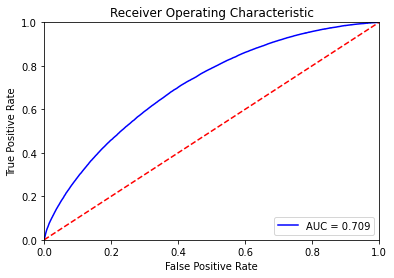

In [109]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [110]:
print(roc_auc)

0.7089475488614744


In [111]:
from sklearn.ensemble import RandomForestClassifier

In [112]:
tree_model = RandomForestClassifier(max_depth=15, n_estimators=50)
tree_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=50)

In [113]:
y_pred = tree_model.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.9247763374109914


In [236]:
with open('rand_forest.pkl', 'wb') as f:
    pkl.dump(tree_model, f)

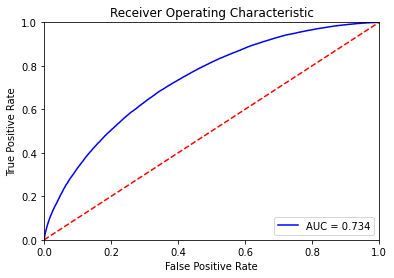

In [114]:
y_pred_proba = tree_model.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [115]:
print(roc_auc)

0.7341395202730534


In [120]:
user_prod_df = pd.read_csv(Path('/kaggle/input', 'sbermarket-user-prod-data', 'user_prod_data.csv'))

In [121]:
user_prod_df.head()

,user_id,product_id,master_category_id,parent_category_id,order_id_nuni,quantity_median,price,discount,prod_type
0,51,487,38.0,35,3,1.0,165.336665,21.333333,5
1,51,539,38.0,35,1,1.0,153.000000,0.000000,5
2,51,562,36.0,35,7,1.0,267.478570,22.998571,7
3,51,1309,574.0,9,1,1.0,42.990002,0.000000,21
4,51,1989,32.0,20,1,1.0,93.900002,0.000000,32


In [ ]:
def sort_basket(basket):
    users = []
    orders = []
    prices = []
    product_names = []
    brand_names = []
    master_category_ids = []
    parent_category_ids = []
    
    for prod in basket:
        users.append(user_prod_df.user_id[user_prod_df.product_id == prod].iloc[0])
        

In [116]:
sub_df = pd.read_csv(Path('/kaggle/input/hack-sbermarket/dummy_submission.csv'))

In [117]:
sub_df.head()

,Id,Predicted
0,51,55079 6005183 63057 3817487 655 2589299 58780 ...
1,65,63048 5479458 18439 2063 57289 26062 18450 105...
2,187,88084 88086 55079 6005183 63057 3817487 655 25...
3,400,57085 50068 0 58137 64975 63696 18887 407 2675...
4,576,2600 177 4431 4656 7064842 7048764 21505 60105...


In [246]:
sub_df.iloc[0][1].split()

['55079',
 '6005183',
 '63057',
 '3817487',
 '655',
 '2589299',
 '58780',
 '800',
 '5481291',
 '802',
 '45435',
 '4275967',
 '67407',
 '4033524',
 '5075820',
 '72146',
 '3562687',
 '9979',
 '95961',
 '3562686',
 '84365',
 '65140',
 '56900',
 '59072',
 '5476648',
 '5851',
 '19562',
 '57398',
 '5063195',
 '57399',
 '4276103',
 '661',
 '3559099',
 '3033428',
 '5501',
 '84176',
 '5062466',
 '7061902',
 '64633',
 '2546',
 '2545',
 '7723',
 '7742',
 '7740',
 '7795',
 '24687',
 '7352',
 '3819828',
 '5468894',
 '87007']

In [ ]:
my_dummy_submission = sbermarket_tab_2_sample_submission[['user_id', 'product_id']].copy()
my_dummy_submission['product_id']  = my_dummy_submission['product_id'].apply(lambda s: str(s) + ' ')
my_dummy_submission = my_dummy_submission.groupby('user_id').product_id.sum().to_frame('product_id').reset_index()
my_dummy_submission.product_id = my_dummy_submission.product_id.apply(lambda s: s.split()[:50])
my_dummy_submission['product_id_added'] = my_dummy_submission.product_id
some_prod = my_dummy_submission.product_id_added.values[0]
my_dummy_submission.product_id_added = my_dummy_submission.product_id_added.apply(lambda s: s + some_prod[:50-len(s)])
dummy_submission = my_dummy_submission[['user_id', 'product_id_added']]
dummy_submission['Predicted'] = dummy_submission.product_id_added.apply(lambda s: ' '.join(prod for prod in s))
dummy_submission['Id'] = dummy_submission.user_id
dummy_submission = dummy_submission[['Id', 'Predicted']]
# dummy_submission.to_csv('/kaggle/working/dummy_submission.csv', index=False)

# Add orders to users

In [50]:
orders_df = pd.read_csv(Path(general_folder, most_of_tab_subfolder, 'tab_1_orders.csv'))
orders_df = orders_df.drop_duplicates()
# prods_df = pd.read_csv(Path(general_folder, 'sbermarket_tab_2_1/tab_2_products_2020-03-11.csv'))

In [33]:
orders_df.head()

,user_id,order_id,order_created_time,retailer,store_id,platform
1391919,1719384,17843257,2020-10-01 20:59:11,METRO,94,app
2459416,3387406,17843230,2020-10-01 20:58:01,Лента,301,app
2415678,3204913,17843224,2020-10-01 20:57:54,METRO,320,app
857780,1257943,17843217,2020-10-01 20:57:34,METRO,126,app
2459412,3387396,17843206,2020-10-01 20:57:01,METRO,91,web


In [22]:
orders_df.isna().sum()

user_id               0
order_id              0
order_created_time    0
retailer              0
store_id              0
platform              0
dtype: int64

In [23]:
orders_df.nunique()

user_id                753572
order_id              2426955
order_created_time    2230749
retailer                   61
store_id                  738
platform                    3
dtype: int64

In [24]:
orders_df['order_created_time'] = pd.to_datetime(orders_df['order_created_time'], format='%Y-%m-%d %H:%M:%S')

In [25]:
orders_df = orders_df.sort_values('order_created_time', ascending=False)
orders_df.head()

,user_id,order_id,order_created_time,retailer,store_id,platform
1391919,1719384,17843257,2020-10-01 20:59:11,METRO,94,app
2459416,3387406,17843230,2020-10-01 20:58:01,Лента,301,app
2415678,3204913,17843224,2020-10-01 20:57:54,METRO,320,app
857780,1257943,17843217,2020-10-01 20:57:34,METRO,126,app
2459412,3387396,17843206,2020-10-01 20:57:01,METRO,91,web


In [26]:
orders_df = orders_df.drop_duplicates('order_id')

In [27]:
orders_df.head()

,user_id,order_id,order_created_time,retailer,store_id,platform
1391919,1719384,17843257,2020-10-01 20:59:11,METRO,94,app
2459416,3387406,17843230,2020-10-01 20:58:01,Лента,301,app
2415678,3204913,17843224,2020-10-01 20:57:54,METRO,320,app
857780,1257943,17843217,2020-10-01 20:57:34,METRO,126,app
2459412,3387396,17843206,2020-10-01 20:57:01,METRO,91,web


In [28]:
def get_latest_order_id(user_id, shift=0):
    return orders_df[orders_df.user_id == user_id].order_id.iloc[shift]


def remove_dead_orders(prods_df):
    return prods_df[prods_df.user_id.isin(orders_df.user_id)]

In [31]:
orders_df.dtypes

user_id                        int64
order_id                       int64
order_created_time    datetime64[ns]
retailer                      object
store_id                       int64
platform                      object
dtype: object

In [35]:
prods_df.iloc[120:125]

,product_id,user_id,order_id,line_item_id,price,quantity,discount,product_name,brand_name,master_category_id,parent_category_id
120,3818767,65,6557592,40877437,165.000000,1,21.00,Краска Дивидик для изделий из гладкой кожи кор...,Дивидик,288.0,286
121,3817542,65,6557592,40877438,59.790001,1,4.92,Апельсины,Без бренда,91.0,90
122,18439,65,6557592,40877441,37.689999,2,0.00,Творог Lactica Мягкий диетический обезжиренный...,Lactica,30.0,20
123,2063,65,6557592,40877442,202.000000,1,0.00,Конфитюр Zuegg абрикос,Zuegg,604.0,67
124,57289,65,6557592,40877443,45.889999,2,0.00,Йогурт Epica натуральный 6% 130 г бзмж,Epica,21.0,20


In [36]:
prods_df = remove_dead_orders(prods_df)
prods_df.head()

,product_id,user_id,order_id,line_item_id,price,quantity,discount,product_name,brand_name,master_category_id,parent_category_id
153,3042629,766,6951114,42098996,84.230003,1,0.0,"Кефир Маруся 3,5-4,5% 930 мл",Маруся,28.0,20
154,3041850,766,6951114,42098997,68.599998,3,0.0,Молоко Маруся пастеризованное 1% 930 мл,Маруся,26.0,20
155,3043457,766,6951114,42098998,242.020004,4,0.0,Творог Маруся 9% 500 г,Маруся,30.0,20
156,3497511,766,6951114,42098999,87.650002,1,0.0,Яблоки Айдаред,Без бренда,91.0,90
157,4224677,766,6951114,42099000,138.259995,1,0.0,Икра Гудвин из тыквы 530 г,Гудвин,625.0,67


In [37]:
orders_df.drop('user_id', axis=1).head()

,order_id,order_created_time,retailer,store_id,platform
1391919,17843257,2020-10-01 20:59:11,METRO,94,app
2459416,17843230,2020-10-01 20:58:01,Лента,301,app
2415678,17843224,2020-10-01 20:57:54,METRO,320,app
857780,17843217,2020-10-01 20:57:34,METRO,126,app
2459412,17843206,2020-10-01 20:57:01,METRO,91,web


In [38]:
prods_df = prods_df.merge(orders_df.drop('user_id', axis=1), on='order_id')

In [39]:
prods_df.insert(0, 'product_id', prods_df.pop('product_id'))

In [40]:
prods_df.head()

,product_id,user_id,order_id,line_item_id,price,quantity,discount,product_name,brand_name,master_category_id,parent_category_id,order_created_time,retailer,store_id,platform
0,3042629,766,6951114,42098996,84.230003,1,0.0,"Кефир Маруся 3,5-4,5% 930 мл",Маруся,28.0,20,2020-03-12 17:52:18,Ашан,70,web
1,3041850,766,6951114,42098997,68.599998,3,0.0,Молоко Маруся пастеризованное 1% 930 мл,Маруся,26.0,20,2020-03-12 17:52:18,Ашан,70,web
2,3043457,766,6951114,42098998,242.020004,4,0.0,Творог Маруся 9% 500 г,Маруся,30.0,20,2020-03-12 17:52:18,Ашан,70,web
3,3497511,766,6951114,42098999,87.650002,1,0.0,Яблоки Айдаред,Без бренда,91.0,90,2020-03-12 17:52:18,Ашан,70,web
4,4224677,766,6951114,42099000,138.259995,1,0.0,Икра Гудвин из тыквы 530 г,Гудвин,625.0,67,2020-03-12 17:52:18,Ашан,70,web


In [41]:
prods_df.nunique()

product_id              43319
user_id                 30144
order_id                35678
line_item_id          1168505
price                   35977
quantity                  104
discount                 5693
product_name            41822
brand_name               4424
master_category_id        485
parent_category_id        107
order_created_time      35322
retailer                    5
store_id                  109
platform                    2
dtype: int64

In [ ]:
def get_prods_from_order(order_id):
    prods_in_order = prods_df[prods_df.order_id == order_id].order_id
    return set(prods_in_order)

In [39]:
orders_time_df = orders_df[['order_id', 'order_created_time']]


order2time = dict()
for i, row in orders_time_df.iterrows():
    order2time[row.order_id] = row.order_created_time

In [ ]:
def get_prev_order(order_id):
#     cur_time = orders_time_df[orders_time_df.order_id == order_id].order_created_time.iloc[0]
    cur_time = order2time[order_id]
    prev_orders = orders_time_df[orders_time_df.order_created_time < cur_time].order_id
    
    if len(prev_orders) > 0:
        prev_order_id = prev_orders.iloc[0]
    else:
        prev_order_id = np.nan
        
    return prev_order_id

In [38]:
orders_time_df[orders_time_df.order_id == 6951114]

,order_id,order_created_time
75,6951114,2020-03-12 17:52:18


In [33]:
order_time_df = prods_df[['order_id', 'order_created_time']]
prods_df['prev_order_id'] = order_time_df['order_id'].apply(get_prev_order)

KeyboardInterrupt: 

# Test sample submission

In [19]:
sample_sub_df = pd.read_csv(Path(general_folder, 'sample_submission.csv'))

In [22]:
sample_sub_df[sample_sub_df.Id.isin(users_df.user_id)].shape

(20412, 2)

In [42]:
prods_df.head()

,product_id,user_id,order_id,line_item_id,price,quantity,discount,product_name,brand_name,master_category_id,parent_category_id,order_created_time,retailer,store_id,platform
0,3042629,766,6951114,42098996,84.230003,1,0.0,"Кефир Маруся 3,5-4,5% 930 мл",Маруся,28.0,20,2020-03-12 17:52:18,Ашан,70,web
1,3041850,766,6951114,42098997,68.599998,3,0.0,Молоко Маруся пастеризованное 1% 930 мл,Маруся,26.0,20,2020-03-12 17:52:18,Ашан,70,web
2,3043457,766,6951114,42098998,242.020004,4,0.0,Творог Маруся 9% 500 г,Маруся,30.0,20,2020-03-12 17:52:18,Ашан,70,web
3,3497511,766,6951114,42098999,87.650002,1,0.0,Яблоки Айдаред,Без бренда,91.0,90,2020-03-12 17:52:18,Ашан,70,web
4,4224677,766,6951114,42099000,138.259995,1,0.0,Икра Гудвин из тыквы 530 г,Гудвин,625.0,67,2020-03-12 17:52:18,Ашан,70,web


In [43]:
sample_sub_df[sample_sub_df.Id.isin(prods_df.user_id)].shape

(7976, 2)